CUDA Convolutional Sparse Coding with Gradient Term
===================================================

This example demonstrates the use of the interface to the CUDA CSC solver extension package, with a test for the availablity of a GPU that runs the Python version of the ConvBPDNGradReg solver if one is not available, or if the extension package is not installed.

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import fft
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()
from sporco import cuda
from sporco.admm import cbpdn

# If running in a notebook, try to use wurlitzer so that output from the CUDA
# code will be properly captured in the notebook.
sys_pipes = util.notebook_system_output()

Load example image.

In [2]:
img = util.ExampleImages().image('barbara.png', scaled=True, gray=True,
                                 idxexp=np.s_[10:522, 100:612])

Load main dictionary and prepend an impulse filter for lowpass component representation.

In [3]:
Db = util.convdicts()['G:12x12x36']
di = np.zeros(Db.shape[0:2] + (1,), dtype=np.float32)
di[0, 0] = 1
D = np.concatenate((di, Db), axis=2)

Set up weights for the $\ell_1$ norm to disable regularization of the coefficient map corresponding to the impulse filter.

In [4]:
wl1 = np.ones((1,)*2 + (D.shape[2:]), dtype=np.float32)
wl1[..., 0] = 0.0

Set of weights for the $\ell_2$ norm of the gradient to disable regularization of all coefficient maps except for the one corresponding to the impulse filter.

In [5]:
wgr = np.zeros((D.shape[2]), dtype=np.float32)
wgr[0] = 1.0

Set up [admm.cbpdn.ConvBPDNGradReg](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNGradReg) options.

In [6]:
lmbda = 1e-2
mu = 5e-1
opt = cbpdn.ConvBPDNGradReg.Options({'Verbose': True, 'MaxMainIter': 250,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False, 'AutoRho': {'Enabled': False},
                    'rho': 0.5, 'L1Weight': wl1, 'GradWeight': wgr})

If GPU available, run CUDA ConvBPDNGradReg solver, otherwise run standard Python version.

In [7]:
if cuda.device_count() > 0:
    print('%s GPU found: running CUDA solver' % cuda.device_name())
    tm = util.Timer()
    with sys_pipes(), util.ContextTimer(tm):
        X = cuda.cbpdngrd(D, img, lmbda, mu, opt)
    t = tm.elapsed()
else:
    print('GPU not found: running Python solver')
    c = cbpdn.ConvBPDNGradReg(D, img, lmbda, mu, opt)
    X = c.solve().squeeze()
    t = c.timer.elapsed('solve')
print('Solve time: %.2f s' % t)

GeForce RTX 2080 Ti GPU found: running CUDA solver


Itn   Fnc       DFid      Regℓ1     Regℓ2∇     r         s         ρ
--------------------------------------------------------------------------
   0  2.68e+07  1.30e+07  4.85e+04  2.76e+07  4.45e-01  9.48e+00  5.00e-01
   1  6.94e+07  3.32e+07  4.50e+04  7.26e+07  1.19e-01  2.28e+00  5.00e-01
   2  5.95e+07  2.79e+07  3.49e+04  6.33e+07  6.07e-02  7.70e-01  5.00e-01
   3  6.15e+07  2.87e+07  2.79e+04  6.57e+07  4.56e-02  5.12e-01  5.00e-01
   4  6.17e+07  2.87e+07  2.27e+04  6.59e+07  3.64e-02  4.01e-01  5.00e-01
   5  6.17e+07  2.87e+07  1.93e+04  6.60e+07  3.00e-02  3.33e-01  5.00e-01
   6  6.21e+07  2.90e+07  1.65e+04  6.62e+07  2.50e-02  2.85e-01  5.00e-01
   7  6.21e+07  2.89e+07  1.43e+04  6.64e+07  2.09e-02  2.53e-01  5.00e-01
   8  6.22e+07  2.90e+07  1.26e+04  6.66e+07  1.78e-02  2.24e-01  5.00e-01
   9  6.23e+07  2.89e+07  1.12e+04  6.67e+07  1.52e-02  2.01e-01  5.00e-01
  10  6.24e+07  2.90e+07  1.01e+04  6.68e+07  1.32e-02  1.80e-01  5.00e-01
  11  6.24e+07  2.89e+07  9.22e

Reconstruct the image from the sparse representation.

In [8]:
imgr = np.sum(fft.fftconv(D, X, axes=(0, 1)), axis=2)
print("Reconstruction PSNR: %.2fdB\n" % metric.psnr(img, imgr))

Reconstruction PSNR: 45.50dB



Display representation and reconstructed image.

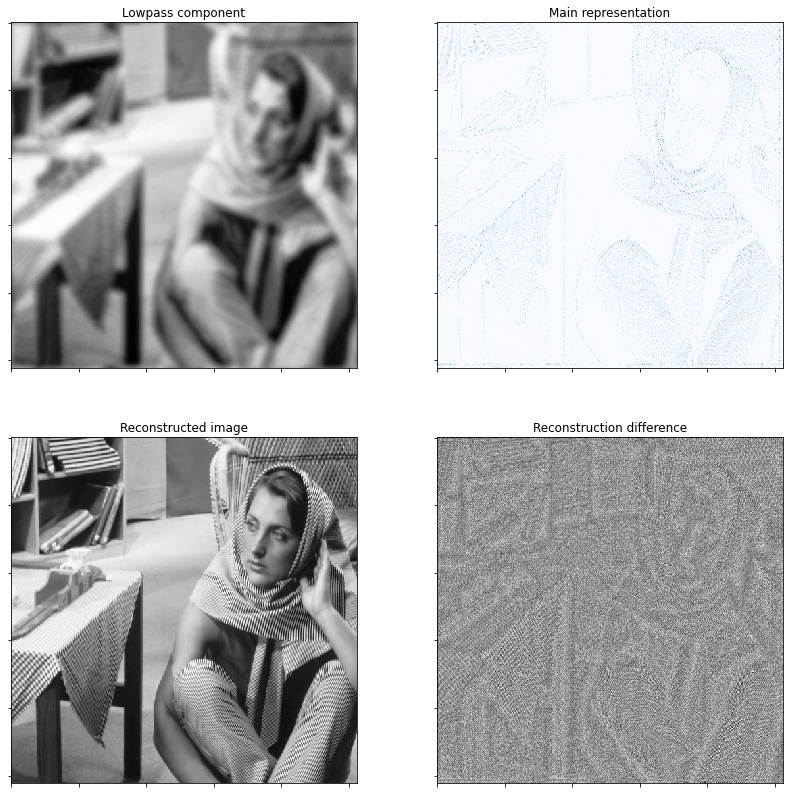

In [9]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(X[..., 0].squeeze(), title='Lowpass component', fig=fig)
plot.subplot(2, 2, 2)
plot.imview(np.sum(abs(X[..., 1:]), axis=2).squeeze(),
            cmap=plot.cm.Blues, title='Main representation', fig=fig)
plot.subplot(2, 2, 3)
plot.imview(imgr, title='Reconstructed image', fig=fig)
plot.subplot(2, 2, 4)
plot.imview(imgr - img, fltscl=True, title='Reconstruction difference',
            fig=fig)
fig.show()